2024-03-01 22:51:32,812 - INFO - Configuration loaded successfully.
2024-03-01 22:51:32,820 - INFO - Data loaded successfully from ..//data//raw//diabetes.csv



Adjusted Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        99
           1       0.66      0.71      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



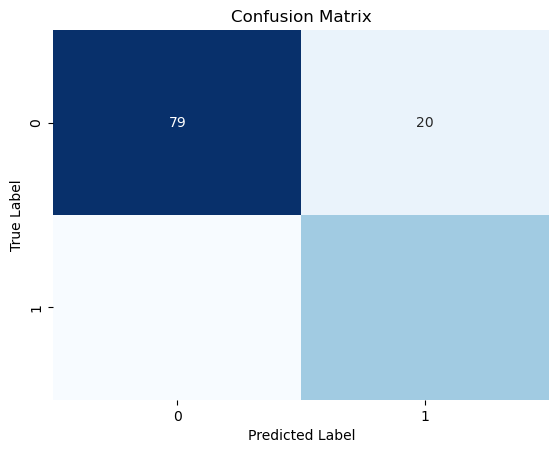

2024-03-01 22:53:00,475 - INFO - Configuration loaded successfully.


Processed data successfully saved to ..//data//processed//diabetes_processed.csv


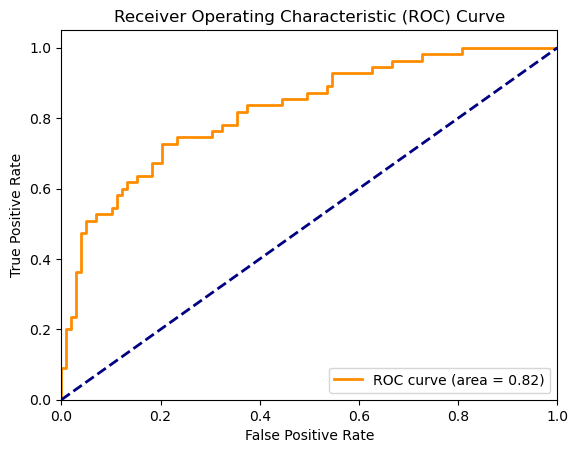

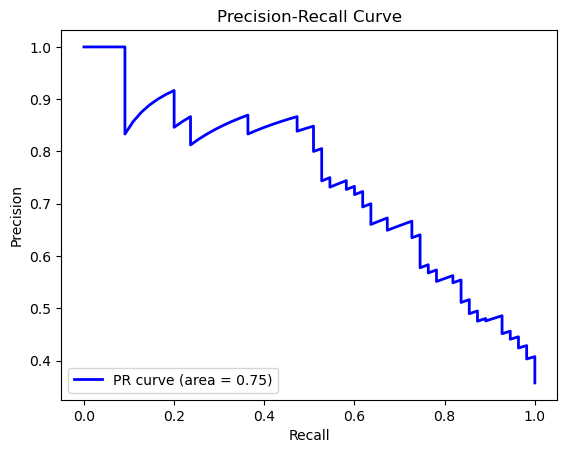

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
import sys 
sys.path.append('../Helpers')
from data_helpers import load_config, load_data


# Data loading and preprocessing
def load_and_preprocess_data(config_path):
    # Load configuration settings from a JSON file
    config = load_config(config_path)

    if not config:
        raise Exception("Failed to load configuration.")

    # Load the dataset
    data_path = config['data_path']
    df = load_data(data_path)

    if df is None:
        raise Exception("Failed to load the data.")

    # Handling missing values
    for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
        df[col].replace(0, np.nan, inplace=True)
        
    df['BMI_Age_Interaction'] = df['BMI'] * df['Age']
    
    return df

# Splitting dataset
def split_dataset(df):
    X = df.drop('Outcome', axis=1)
    y = df['Outcome']
    return train_test_split(X, y, test_size=0.2, random_state=42)


# Revised model pipeline construction with class weight handling
def build_model_pipeline(class_weight):
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()
    poly = PolynomialFeatures(degree=2, include_bias=False)
    classifier = RandomForestClassifier(random_state=42, class_weight=class_weight)

    pipeline = Pipeline(steps=[('imputer', imputer),
                               ('scaler', scaler),
                               ('poly', poly),
                               ('classifier', classifier)])
    return pipeline

# Hyperparameter tuning using grid search
def hyperparameter_tuning(X_train, y_train, class_weight):
    pipeline = build_model_pipeline(class_weight)
    parameter_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
    cv = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(pipeline, parameter_grid, cv=cv, scoring='recall')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_



# Function to find the optimal threshold for classification
def find_optimal_threshold(precision, recall, thresholds):
    # Convert to a f1 score and find the index of the highest score
    f1_scores = 2 * recall * precision / (recall + precision)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

# Updated model evaluation with Precision-Recall curve and optimal threshold calculation
def evaluate_model(pipeline, X_test, y_test):
    # Predict probabilities and compute the probabilities for the positive class
    probabilities = pipeline.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC AUC score
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    

    # Compute Precision-Recall curve and PR AUC score
    precision, recall, pr_thresholds = precision_recall_curve(y_test, probabilities)
    pr_auc = average_precision_score(y_test, probabilities)


    # Find the optimal threshold from the precision-recall curve
    optimal_threshold = find_optimal_threshold(precision, recall, pr_thresholds)
    
    # Adjust predictions based on the optimal threshold
    adjusted_predictions = [1 if prob > optimal_threshold else 0 for prob in probabilities]
    
    # Classification report using adjusted predictions
    print("\nAdjusted Classification Report:")
    print(classification_report(y_test, adjusted_predictions))

    # Plot adjusted confusion matrix
    adjusted_cm = confusion_matrix(y_test, adjusted_predictions)
    plot_confusion_matrix(adjusted_cm)
    plot_roc_curve(y_test, probabilities)
    
def save_processed_data(df, config_path):
    """
    Saves the processed DataFrame to a CSV file and handles errors.
    
    Parameters:
    - df: DataFrame to save
    - config_path: Path to the configuration file
    """
    try:
        config = load_config(config_path)
        processed_data_path = config['processed_data_path']
        df.to_csv(processed_data_path, index=False)
        print(f"Processed data successfully saved to {processed_data_path}")
    except Exception as e:
        print(f"Failed to save processed data: {e}")

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(recall, precision, pr_auc):
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    


def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    
    
    
    
    # Function to plot the ROC curve
def plot_roc_curve(y_test, probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    
    
    
# Main execution block
if __name__ == "__main__":
    config_path = '../config/config.json' 
    df = load_and_preprocess_data('../config/config.json')
    X_train, X_test, y_train, y_test = split_dataset(df)
    
    # Compute class weights for imbalanced classes
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Perform hyperparameter tuning
    best_pipeline = hyperparameter_tuning(X_train, y_train, class_weight_dict)
    
    # Evaluate the best model
    evaluate_model(best_pipeline, X_test, y_test)
    
    # Save the processed data
    save_processed_data(df, config_path)

    # Compute Precision-Recall curve and PR AUC score for plotting
    probabilities = best_pipeline.predict_proba(X_test)[:, 1]  # For PR AUC score
    precision, recall, _ = precision_recall_curve(y_test, probabilities)
    pr_auc = average_precision_score(y_test, probabilities)
    
    # Correct call to plot_precision_recall_curve with all necessary arguments
    plot_precision_recall_curve(recall, precision, pr_auc)